In [1]:
# UFRJ/COPPE/PEE - Processamento de Sinais Aleatórios - 2019.3
# Professor: Luiz Wagner Pereira Biscainho
# Exercicio C2 - Projeto de filtro passa-baixas utilizando metodos de Pade e Prony
# Aluna: Maria Gabriella Andrade Felgas

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, linalg

In [2]:
# Definindo parametros
wc1 = np.pi / 2
wc2 = np.pi / 16
nd = 5
num_samples = 50

# Inicializando as respostas ao impulso
h1 = np.zeros((num_samples))
h2 = np.zeros((num_samples))

In [3]:
# Gerando as amostras do sinal

for n in range(num_samples):
    if n == nd:
        h1[n] = 1 / 2
        h2[n] = 1 / 2
    else:
        h1[n] = np.sin((n - nd) * wc1) / ((n - nd) * np.pi)
        h2[n] = np.sin((n - nd) * wc2) / ((n - nd) * np.pi)

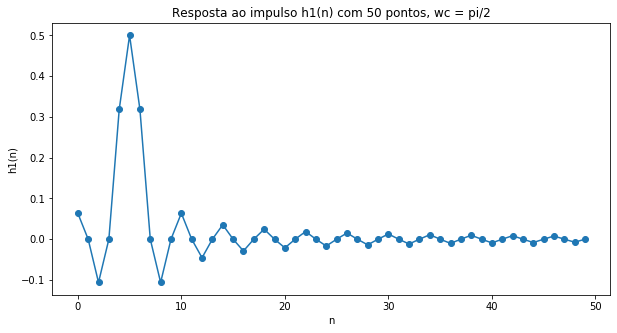

In [4]:
plt.figure(figsize=(10, 5))

plt.plot(h1, 'o-')
plt.title('Resposta ao impulso h1(n) com 50 pontos, wc = pi/2')
plt.xlabel('n')
plt.ylabel('h1(n)')

plt.show()

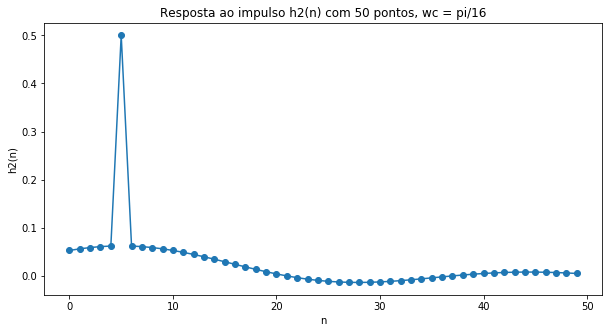

In [5]:
plt.figure(figsize=(10, 5))

plt.plot(h2, 'o-')
plt.title('Resposta ao impulso h2(n) com 50 pontos, wc = pi/16')
plt.xlabel('n')
plt.ylabel('h2(n)')

plt.show()

In [6]:
# Funcao que monta a matriz toeplitz
# para resolver o sistema de equacoes

def convm(x, p):
    padding = np.zeros(p, x.dtype)
    
    first_col = x
    first_row = np.r_[x[0], padding]
    
    conv_matrix = linalg.toeplitz(first_col, first_row)
    
    return conv_matrix

In [7]:
# Definindo a funcao que implementa
# a aproximacao de Pade segundo a
# figura 4.3 do livro

def pade(x, p, q):  
    if (p + q) >= x.shape[0]:
        print('Erro: Modelo com ordem muito grande. Tente novamente.')
    
    else:
        # Amostrando a resposta ao impulso
        pade_x = x[:(p + q + 1)]
        
        # Gerando a matriz toeplitz para
        # o sistema de equacoes
        x_matrix = convm(pade_x, p)
        
        # Descobrindo os parametros a(k)
        # de acordo com as equacoes sem dependencia
        # de b(k)
        a_A = x_matrix[(q + 1):(q + p + 1), 1:(p + 1)]
        a_b = x_matrix[(q + 1):(q + p + 1), 0]        
        a = np.linalg.solve(a_A, a_b)
        a = a.reshape((a.shape[0], 1))
        
        # Descobrindo os parametros b(k)
        # de acordo com os valores de a(k)
        # calculados acima
        b_A = x_matrix[:(q + 1), :]        
        b_b = np.vstack(([1], a))        
        b = np.dot(b_A, b_b)
        
        # Contornando o problema de deixar os
        # arrays vazios
        if a.shape[0] == 0:
            a = [1]
        elif b.shape[0] == 0:
            b = [1]

        return a, b

In [9]:
# Aplicando Pade para cada conjunto
# de valores p, q

a = {}
b = {}
H = {}
w = {}
pade_h = {}

for p in range(0, 22, 2):
    q = 20 - p
    a[p], b[p] = pade(h1, p, q)
    w[p], H[p] = signal.freqz(b[p], a[p])
    pade_h[p] = np.fft.ifft(H[p])

C:\Users\gabri\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:570: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


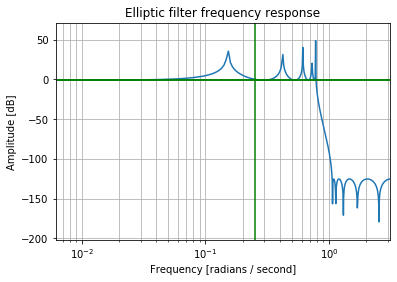

In [10]:
# Projetando o filtro eliptico

wc_ellip = 1 / 4
Rp = 1
Rs = 1
order = 10

b_ellip, a_ellip = signal.ellip(order, Rp, Rs, wc_ellip, btype ='lowpass', analog=False, output='ba')
w_ellip, H_ellip = signal.freqz(b_ellip, a_ellip)
plt.semilogx(w_ellip, 20 * np.log10(abs(H_ellip)))
plt.title('Elliptic filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(wc_ellip, color='green')
plt.axhline(-Rs, color='green')
plt.axhline(-Rp, color='green')
plt.show()